In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
fixing_date = "2023-07-26"
time_format = "%Y-%m-%d"
asset_names = ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"]
df = pd.read_csv("stock_historical_prices.csv")
df.head(5)

,Dates,GOOGL UW Equity,MSFT UW Equity,AAPL UW Equity
0,2/10/2017,48.374,70.1074,36.494
1,3/10/2017,48.604,69.7785,36.653
2,4/10/2017,48.339,70.1826,36.416
3,5/10/2017,49.260,71.3853,36.869
4,6/10/2017,49.682,71.4135,36.847


In [8]:
from datetime import datetime
def preprocess_date(df):
   df["date"] = pd.to_datetime(df["Dates"], format = "%d/%m/%Y")


def calculate_returns(df, asset_names):
   for asset_name in asset_names:
      calculate_return(df, asset_name)

def calculate_return(df, asset_name: str):
   df[asset_name + "_return"] = np.log(df[asset_name] / df[asset_name].shift(1))


In [9]:
preprocess_date(df)
calculate_returns(df, ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"])

In [10]:
df

,Dates,GOOGL UW Equity,MSFT UW Equity,AAPL UW Equity,date,GOOGL UW Equity_return,MSFT UW Equity_return,AAPL UW Equity_return
0,2/10/2017,48.374,70.1074,36.494,2017-10-02,NaN,NaN,NaN
1,3/10/2017,48.604,69.7785,36.653,2017-10-03,0.004743,-0.004702,0.004347
2,4/10/2017,48.339,70.1826,36.416,2017-10-04,-0.005467,0.005774,-0.006487
3,5/10/2017,49.260,71.3853,36.869,2017-10-05,0.018874,0.016992,0.012363
4,6/10/2017,49.682,71.4135,36.847,2017-10-06,0.008530,0.000395,-0.000597
...,...,...,...,...,...,...,...,...
1322,26/10/2022,94.930,231.3200,149.350,2022-10-26,-0.095856,-0.080295,-0.019822
1323,27/10/2022,92.220,226.7500,144.800,2022-10-27,-0.028963,-0.019954,-0.030939
1324,28/10/2022,96.290,235.8700,155.740,2022-10-28,0.043187,0.039433,0.072834
1325,31/10/2022,94.510,232.1300,153.340,2022-10-31,-0.018659,-0.015983,-0.015530


## Abstract modelling class

In [11]:
from abc import ABC, abstractmethod

class AssetModel(ABC):

    start_date: str
    cur_date: str

    def __init__(self, df: pd.DataFrame, fixing_date: str):
        preprocess_date(df)
        self.start_date = df["date"].min()
        self.end_date = df["date"].max()
        self.df = df.set_index("date")
        self.fixing_date = fixing_date

    
    def set_start_date(self, start_date: str):
        self.start_date = start_date

    def set_cur_date(self, cur_date: str):
        self.cur_date = cur_date
    
    def fit_date(self, start_date: str, cur_date: str):
        data = self.df.loc[start_date:cur_date]
        self.fit_model(data)
    
    @abstractmethod
    def fit_model(self, data: pd.DataFrame):
        return NotImplemented

    @abstractmethod   
    def get_predict_price(self, cur_date: str):
        return NotImplemented

    @abstractmethod
    def get_path(self, cur_date: str):
        return NotImplemented


## SingleAssetGBM

In [12]:
## Assumption: data is on daily frequence
## delta_t = 1
class SingleAssetGBM(AssetModel):

    asset_name: str
    r: float
    v: float
    sigma: float

    def __init__(self, df: pd.DataFrame, fixing_date: str, asset_name):
        super().__init__(df, fixing_date)
        self.asset_name = asset_name
        # self.df = self.df[["date", asset_name]]
        calculate_return(self.df, asset_name)


    def fit_model(self, data: pd.DataFrame):
        self.r = data[self.asset_name + "_return"].mean()
        self.v = self.r
        self.sigma = np.sqrt(1 / (len(data) - 1) * np.sum((data[self.asset_name + "_return"] - self.r) ** 2) )


    def get_predict_price(self, cur_date: str):
        self.set_cur_date(cur_date)
        self.fit_date(self.start_date, self.cur_date)
        # print(datetime.strptime(self.cur_date, time_format), datetime.strptime(self.fixing_date, time_format))
        days = np.busday_count( self.cur_date, self.fixing_date)
        
        w = np.random.normal(0, 1)
        print(w)
        return self.df.loc[cur_date, self.asset_name] * np.exp(self.v * days + self.sigma * days * w)


    def get_path(self, cur_date: str):
        self.set_cur_date(cur_date)
        self.fit_date(self.start_date, self.cur_date)
        days = np.busday_count( self.cur_date, self.fixing_date)
        
        w = np.random.normal(0, 1, days)
        price_path = pd.Series(np.exp(self.v + self.sigma * w)).cumprod() * self.df.loc[cur_date, self.asset_name]
        return price_path

In [13]:
google = SingleAssetGBM(df, fixing_date, "GOOGL UW Equity")

In [14]:
cur_date = "2022-07-21"
google.get_predict_price(cur_date)

0.10057725815909134


224.00163295244417

In [15]:
google.r, google.v, google.sigma

(0.0006865235327487374, 0.0006865235327487374, 0.0185005775171534)

In [16]:
(1 + 0.0006865235327487374) ** 1000

1.98632854661763

<AxesSubplot:>

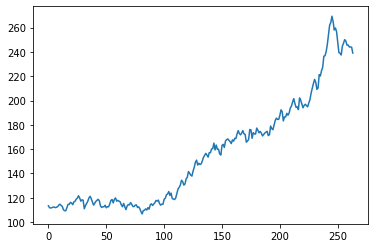

In [17]:
google.get_path(cur_date).plot()

## MultiAssetGBM

In [18]:
## Assumption: data is on daily frequence
## delta_t = 1
class  MultiAssetGBM(AssetModel):

    asset_names: list
    r: float
    v: float
    sigma: float

    def __init__(self, df: pd.DataFrame, fixing_date: str, asset_names: list):
        super().__init__(df, fixing_date)
        self.asset_names = asset_names
        calculate_returns(self.df, asset_names)
        self.return_names = [x + "_return" for x in self.asset_names]
        self.no_of_assets = len(self.asset_names)

    def fit_model(self, data: pd.DataFrame):
        returns = data[self.return_names]
        self.r = returns.mean()
        self.v = self.r
        self.sigma = np.sqrt(returns.cov())


    def get_predict_price(self, cur_date: str):
        self.set_cur_date(cur_date)
        self.fit_date(self.start_date, self.cur_date)
        # print(datetime.strptime(self.cur_date, time_format), datetime.strptime(self.fixing_date, time_format))
        days = np.busday_count( self.cur_date, self.fixing_date)
        
        w = np.random.normal(0, 1, self.no_of_assets)
        print(w)

        self.s_0 = self.df.loc[cur_date, self.asset_names]

        return self.s_0.values * np.exp(self.v * days + self.sigma.transpose() @ w)
        

    def get_path(self, cur_date: str):
        self.set_cur_date(cur_date)
        self.fit_date(self.start_date, self.cur_date)
        days = np.busday_count( self.cur_date, self.fixing_date)
        
        w = np.random.normal(0, 1, (self.no_of_assets, days))
        self.s_0 = self.df.loc[cur_date, self.asset_names]
        return_path =np.exp(np.repeat([self.v.values], [days], axis = 0).transpose() + self.sigma.transpose().values @  w).cumprod(axis = 1)
        price_path = np.diag(self.s_0) @ return_path
        return price_path

In [19]:
multassetGBM = MultiAssetGBM(df, fixing_date, asset_names)

In [20]:

multassetGBM.get_predict_price(cur_date)

[ 0.64292116  0.02214466 -1.75882868]


GOOGL UW Equity_return    134.889493
MSFT UW Equity_return     343.063929
AAPL UW Equity_return     205.297345
dtype: object

In [21]:
multassetGBM.sigma

,GOOGL UW Equity_return,MSFT UW Equity_return,AAPL UW Equity_return
GOOGL UW Equity_return,0.018508,0.016499,0.016049
MSFT UW Equity_return,0.016499,0.018544,0.016883
AAPL UW Equity_return,0.016049,0.016883,0.020146


<AxesSubplot:xlabel='date'>

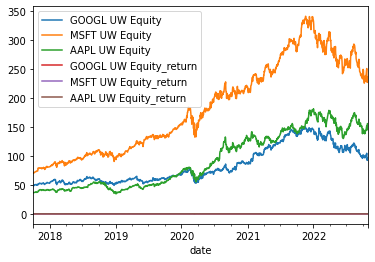

In [22]:
multassetGBM.df.plot()

<AxesSubplot:>

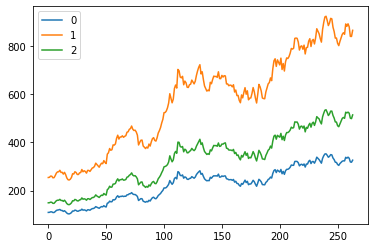

In [23]:
pd.DataFrame(multassetGBM.get_path(cur_date)).transpose().plot()

In [24]:
np.diag(multassetGBM.s_0)

array([[114.34, 0, 0],
       [0, 264.2791, 0],
       [0, 0, 155.135]], dtype=object)

In [25]:
w = np.random.normal(0, 1, (multassetGBM.no_of_assets,250))
multassetGBM.s_0 = multassetGBM.df.loc[cur_date, multassetGBM.asset_names]
return_path = np.exp(np.repeat([multassetGBM.v.values], [250], axis = 0).transpose() + multassetGBM.sigma.transpose().values @  w).cumprod(axis = 1)

In [26]:
return_path.shape

(3, 250)

In [35]:
cur_date

'2022-07-21'

In [58]:
sample_cols = ["GOOGL", "MSFT", "AAPL"]
multassetGBM.set_start_date("2022-01-01")
sample_df = pd.DataFrame(multassetGBM.get_path(cur_date).transpose(), columns = sample_cols, index = pd.bdate_range('2022-07-22', fixing_date, name = "date"))

<AxesSubplot:xlabel='date'>

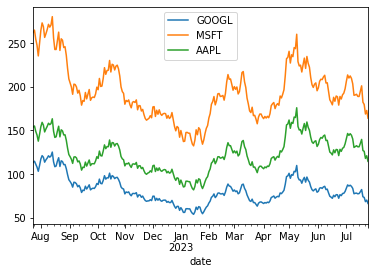

In [59]:
sample_df.plot()

In [60]:
sample_df.to_csv("../generated_data/sample_path.csv")